# Astrostats Assignment 3
## Supernova MH-MCMC exercise
### Indian Institute of Technology, Indore
##### Prasad Rajesh Posture (MSC2303121013)

In [1]:
# Importing the dependencies
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Defining constant
c = 3*10**5 #(km/s) since Hubbles constant is given in km/s/Mpc

In [3]:
# Defining required functions
def a(z):
    return 1/(1+z)

def s(omega_m):
    return ((1-omega_m)/omega_m)**(1/3)

def eta(z, omega_m):
    return 2*np.sqrt(s(omega_m)**3 + 1)*(a(z)**(-4) - 0.1540*(s(omega_m)/(a(z)**3)) + 0.4304*((s(omega_m)/a(z))**2) + 0.19097*((s(omega_m)**3)/a(z)) + 0.066941*(s(omega_m)**4))**(-1/8)

def D_L(z, omega_m, h):
    return (c*(1+z)/(100*h))*(eta(0,omega_m) - eta(z,omega_m))

def mu_th(z, omega_m, h):
    return 25 - 5*np.log10(h) + 5*np.log10(D_L(z, omega_m, h=1))

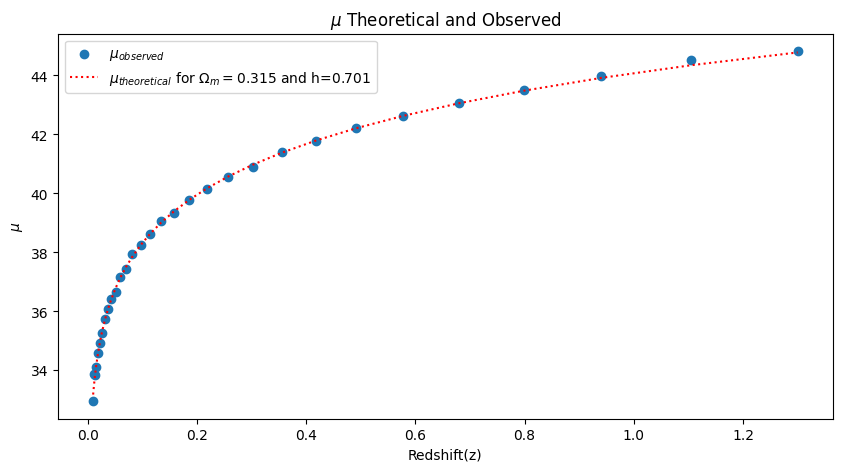

In [4]:
# Reading the data from the given files
data = np.genfromtxt('jla_mub_0.txt')
z = data[:,0]
mu_obs = data[:,1]
plt.figure(figsize=(10,5))
plt.scatter(z, mu_obs, label=r'$\mu_{observed}$')

# Plotted using omega_m and h obtained from previous mh-mcmc exercise
mu_theoretial3 = mu_th(z=z,omega_m=0.315, h=0.701) # Obtained from the previous exercise for reasonable proposal distribution
# here the standard deviation were 0.0316 for both the parameters
plt.plot(z, mu_theoretial3,label=r'$\mu_{theoretical}$ for $\Omega_m=0.315$ and h=0.701', color='red', linestyle=':')

plt.legend()
plt.xlabel('Redshift(z)')
plt.ylabel(r'$\mu$')
plt.title(r"$\mu$ Theoretical and Observed")
plt.savefig('Trials.png')
plt.show()

In [5]:
# Reading the covariant metrics
cov = np.genfromtxt('jla_mub_covmatrix.txt')
cov = cov.reshape(31,31)
inv_cov = np.linalg.inv(cov) #inverse of covariance matrix

# MH-MCMC Algorithm *with* and *without* Prior

In [6]:
# Defining likelihood function
# All the likelihoods are taken in the logarithmic form
def likelihood(mu_obs,z , omega_m, h):
    mu_theoretical = mu_th(z, omega_m, h)
    diff_mu = mu_obs - mu_theoretical
    return (-1/2)*(np.dot(diff_mu, np.dot(inv_cov, diff_mu)))

# Defining a prior for h
# Taking it in logarithmic form
def prior_h(h, mu= 0.738, sigma=0.024):
    return -0.5*((h-mu)/sigma)**2 - np.log(np.sqrt(2*np.pi)*sigma)

In [7]:
# Defining parameters
SNb = 31
sample_n = 1000
param_n = 2
initial_value_h = 1
initial_value_omega_m = 1

# Defining Metropolis-Hasting Algorithm
def MCMC_MH(omega_m_pre, h_pre, sigma_omega, sigma_h, Distribution, prior):
    if Distribution=='Gaussian':
    # Proposal Distribution: Gaussian
        omega_m_nxt = np.abs(np.random.normal(omega_m_pre,sigma_omega)) 
        h_nxt = np.abs(np.random.normal(h_pre, sigma_h))
    else:
    # use uniform proposal distribution
        omega_m_nxt = np.abs(np.random.uniform(omega_m_pre-sigma_omega, omega_m_pre+sigma_omega)) 
        h_nxt = np.abs(np.random.uniform(h_pre-sigma_h, h_pre+sigma_h)) 

    pre_likelihood = likelihood(mu_obs, z, omega_m_pre, h_pre)
    nxt_likelihood = likelihood(mu_obs, z, omega_m_nxt, h_nxt)

    # Adding the prior (since its in log scale)
    if prior==True:
        pre_likelihood = pre_likelihood+prior_h(h_pre)
        nxt_likelihood = nxt_likelihood+prior_h(h_nxt)
    else:
        pass

    # Calculating the acceptance ratio
    acceptance_ratio  = nxt_likelihood - pre_likelihood #Since taken log

    if np.log(np.random.rand())<acceptance_ratio:
#     if 0<acceptance_ratio:               # Choosing the only the parameters with better likelihood than the previous one
        return omega_m_nxt, h_nxt, True
    else:
        return omega_m_pre, h_pre, False
    
# Doing MH-MCMC for different values of standard deviations in omega_m and h
def MCMC_MH_sigmas(sigma_omega, sigma_h, Distribution, prior):

    # Array to store the values
    h_values = [initial_value_h]
    omega_m_values = [initial_value_omega_m]
    likelihood_values = []

    # Doing the random walk using the defined function
    for i in range(1, sample_n):
        omega_m_pre = omega_m_values[-1]
        h_pre = h_values[-1]
        omega_m_nxt, h_nxt, accepted = MCMC_MH(omega_m_pre, h_pre, sigma_omega, sigma_h, Distribution, prior)

        if accepted:
            omega_m_values.append(omega_m_nxt)
            h_values.append(h_nxt)

            likelihood_values.append(likelihood(mu_obs, z, omega_m_nxt, h_nxt))
    
    return h_values, omega_m_values, likelihood_values

# Plotting the chain obtained during the random walk
# Along with the observed and theoretical values of distance modulus using the average values of parameters obtained
def plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean, sigma_omega, prior):
    # Plot of Random Walker Chain
    plt.scatter(omega_m_values[1:], h_values[1:], c=likelihood_values, cmap="BuPu")
    plt.ylabel("h")
    plt.xlabel(r"$\Omega_m$")
    if prior==True:
        plt.title("Random Walk of MH-MCMC with Prior")
    else:
        plt.title("Random Walk of MH-MCMC without Prior")
    plt.colorbar(label='likelihood')
    plt.savefig(f'RandomWalk{str(sigma_omega)+str(prior)}.png')
    plt.show()
    # Comparative plot of
    plt.figure(figsize=(10,5))
    plt.scatter(z, mu_obs, label=r'$\mu_{observed}$')

    # Plotting with 
    mu_theoretical= mu_th(z=z,omega_m=omega_m_mean, h=h_mean)
    plt.plot(z, mu_theoretical,label=r'$\mu_{theoretical}$', color='r',linestyle='--')
    plt.legend()
    plt.xlabel('Redshift(z)')
    plt.ylabel(r'$\mu$')
    plt.title(f"Plot of Distance Modulus with $\Omega_m$:{round(omega_m_mean,3)}, h:{round(h_mean,3)}, Prior:{prior}")
    plt.savefig(f'MCMC{str(sigma_omega)+str(prior)}.png')
    plt.show()

    # Root Mean Square Error to Estimate the difference between observed values and theoretical values given by the set of parameters
    # It helps us with parameters which are closer and give plot that can't directly be differentiated
    print("RMSE:",np.sqrt(np.mean((mu_obs-mu_theoretical)**2)))


# Importance Sampling
In importance sampling, we sample from a proposal distribution (typically the likelihood) and then re-weight the samples based on the prior distribution. This helps us estimate the properties of the posterior distribution.
The weights in importance sampling represent the contribution of each sample to the overall estimate. Samples with higher weights contribute more to the estimate.


### MH-MCMC Random Walk *without* Prior (Flat Prior)

Burned Points: 244
Mean Value of Matter Density without Prior: 0.28641484573243153
Mean Value of Hubble Constant without Prior: 0.7044841347687247
Acceptance Ratio:48.8%
Variance in Matter Density without Prior: 0.0012521198824632196
Variance in Hubble Constant without Prior: 6.493799088736727e-05
Covariance in Both Paramaters: -0.00019165273612802022


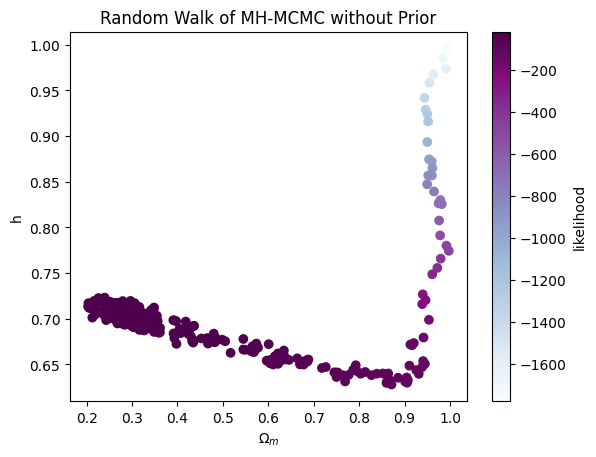

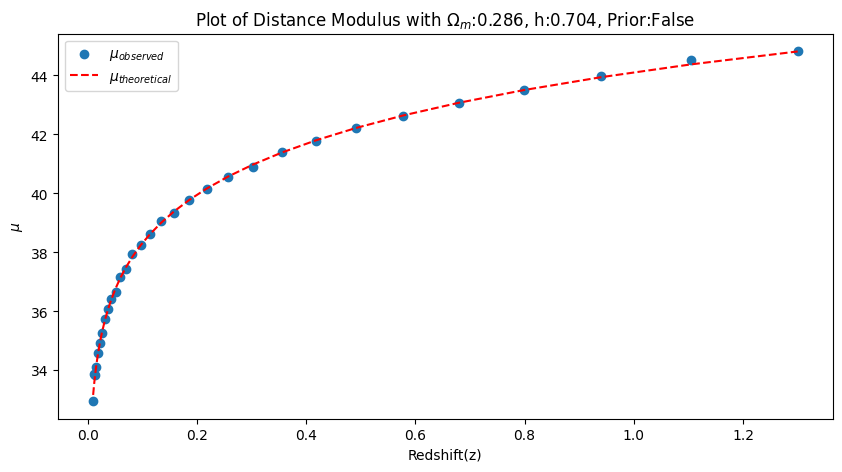

RMSE: 0.0866237846956109


In [8]:
sigma_omega = 0.01
sigma_h = 0.01
h_values, omega_m_values, likelihood_values = MCMC_MH_sigmas(sigma_omega, sigma_h, Distribution='Gaussian', prior=False) # No Prior
burned = round(5*(len(h_values))/10)
print("Burned Points:",burned)
omega_post_burning = omega_m_values[burned:]
h_post_burning = h_values[burned:]
omega_m_mean = np.mean(omega_post_burning)
print("Mean Value of Matter Density without Prior:", omega_m_mean)
h_mean = np.mean(h_post_burning)
print("Mean Value of Hubble Constant without Prior:", h_mean)
print(f"Acceptance Ratio:{len(h_values)/10}%")
print("Variance in Matter Density without Prior:",np.var(omega_post_burning))
print("Variance in Hubble Constant without Prior:", np.var(h_post_burning))
print("Covariance in Both Paramaters:",np.cov(omega_post_burning, h_post_burning)[0,1])
plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean, sigma_omega, prior=False);

Values of the parameters are not much accurate when we don't consider the prior for the given standard deviation.

### MH-MCMC Random Walk *with* Prior

Burned Points: 252
Mean Value of Matter Density with Prior: 0.30337891030331027
Mean Value of Average Value of Hubble Constant with Prior: 0.7033758732047836
Acceptance Ratio:50.4%
Variance in Matter Density with Prior: 0.0014397690314799714
Variance in Hubble Constant with Prior: 5.846918435585503e-05
Covariance in Both Paramaters: -0.00019184315240345162


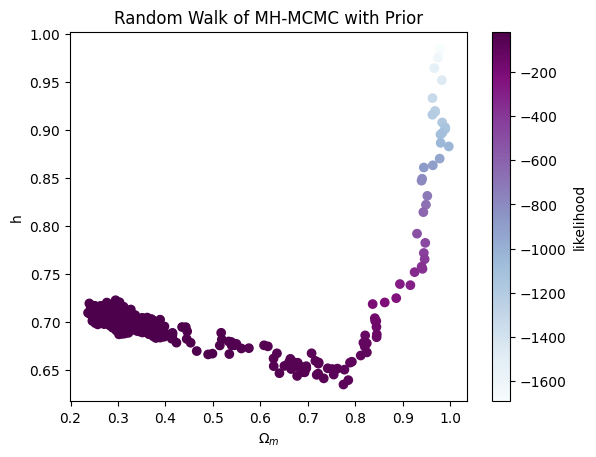

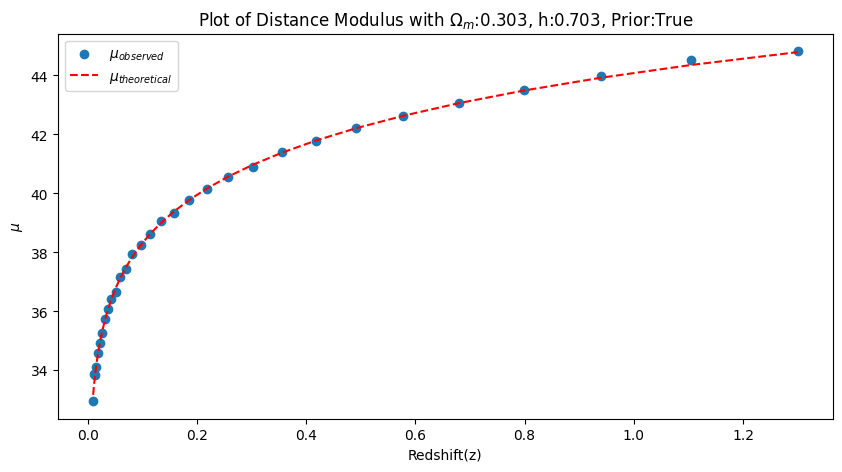

RMSE: 0.0881553816156189


In [9]:
sigma_omega = 0.01
sigma_h = 0.01
h_values, omega_m_values, likelihood_values = MCMC_MH_sigmas(sigma_omega, sigma_h, Distribution='Gaussian', prior=True) # with Prior
burned = round(5*(len(h_values))/10)
print("Burned Points:",burned)
omega_post_burning = omega_m_values[burned:]
h_post_burning = h_values[burned:]
omega_m_mean = np.mean(omega_post_burning)
print("Mean Value of Matter Density with Prior:", omega_m_mean)
h_mean = np.mean(h_post_burning)
print("Mean Value of Average Value of Hubble Constant with Prior:", h_mean)
print(f"Acceptance Ratio:{len(h_values)/10}%")
print("Variance in Matter Density with Prior:",np.var(omega_post_burning))
print("Variance in Hubble Constant with Prior:", np.var(h_post_burning))
print("Covariance in Both Paramaters:",np.cov(omega_post_burning, h_post_burning)[0,1])
plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean, sigma_omega, prior=True)

After considering the prior, the estimated parameter values are closer to the true parameter values and hence the RMSE has reduced.

### Weighted Means of Parameters
1. For each sample, we calculate its weight by dividing its likelihood under the target distribution by its likelihood under the proposal distribution. This represents how much the sample contributes to the estimate of the target distribution.

   $$ \text{Weight}_i = \frac{p_{\text{target}}(x_i)}{p_{\text{proposal}}(x_i)}$$
1. In here, we calculate of weights from the values of likelihood with prior, since we have taken log of likelihood and prior we have convert them back by taking the exponetial.
3. After calculating the weights associated with each sample we normalize them by dividing them with the sum of weights
4. Then we multiply normalized weights with parameters to get the weighted mean of parameters<br>
weighted_mean_parameter = sum(normalized_weights*parameter_samples)

Weight Mean of Omega_m:0.29987274682908166
Weighted Mean of h:0.7031943760614228


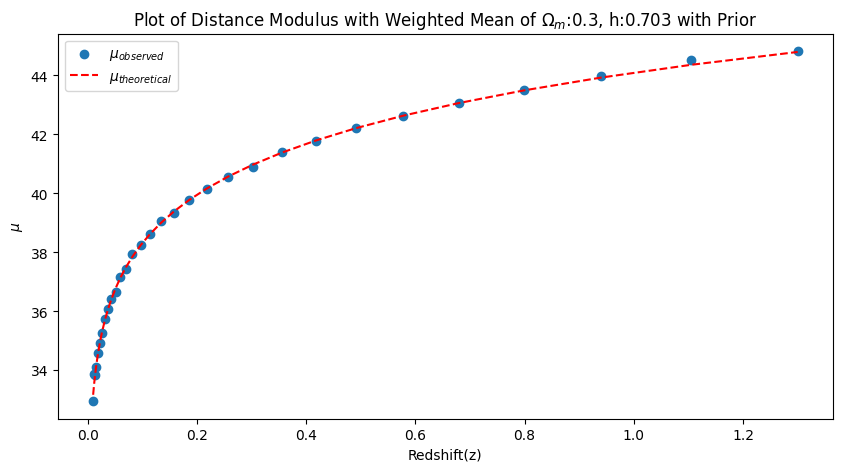

RMSE: 0.08769927772136722


In [10]:
sigma_omega = 0.01
sigma_h = 0.01
norm_weights = np.exp(likelihood_values)/np.sum(np.exp(likelihood_values))
weighted_mean_h = np.sum(norm_weights*h_values[1:])
weighted_mean_omega_m = np.sum(norm_weights*omega_m_values[1:])

print(f"Weight Mean of Omega_m:{weighted_mean_omega_m}")
print(f"Weighted Mean of h:{weighted_mean_h}")
# Comparative plot of
plt.figure(figsize=(10,5)) 
plt.scatter(z, mu_obs, label=r'$\mu_{observed}$')
mu_theoretical= mu_th(z=z,omega_m=weighted_mean_omega_m, h=weighted_mean_h)
plt.plot(z, mu_theoretical,label=r'$\mu_{theoretical}$', color='r',linestyle='--')
plt.legend()
plt.xlabel('Redshift(z)')
plt.ylabel(r'$\mu$')
plt.title(f"Plot of Distance Modulus with Weighted Mean of $\Omega_m$:{round(weighted_mean_omega_m,3)}, h:{round(weighted_mean_h,3)} with Prior")
plt.savefig(f'MCMC{str(sigma_omega)}.png')
plt.show()
print("RMSE:",np.sqrt(np.mean((mu_obs-mu_theoretical)**2)))

### Inference
1. We did not perform the burn-in process, which was done to obtain the previous two plots.
2. In the previous cases, the burn-in process was necessary because we assigned equal importance (i.e., weights) to each parameter. Therefore, it was essential to select parameters that are closer to our target distribution to obtain appropriate mean values for our model parameters.
3. However, when computing the weighted mean of the parameters, it is evident that the weights of parameters located far from the target distribution are lower since the likelihood values are lower. This is because they have lower likelihood (with prior) values, thus making a negligible contribution to the calculation of parameter values and giving us accurate values without havint to do the burn in process.
4. **Additionally, taking the weights gives the best estimate of the parameters for given set of standard deviation with least RMSE**

# Gelman-Rubin Test

The Gelman-Rubin test is used to assess the convergence of Markov Chain Monte Carlo (MCMC) chains. The idea behind this test is to compare the variance of multiple MCMC chains to the variance within each chain. If the chains have converged to the same distribution, their variances should be similar. The Gelman-Rubin test quantifies this by calculating a ratio of the between-chain variance to the within-chain variance. If this ratio (the potential scale reduction factor) is close to 1, it suggests convergence.<br><br>
If $N_s$ and $N_c$ are the number of samples in a chain and number of chains respectively, then the algorithm to calculate the Gelman-Rubin statistics is as follows:<br>
 
1. Calculate the mean of each chain
$$\bar{x_c} = \frac{1}{N_s} \sum_{s=1}^{N_s}x_{c,s} $$

2. Calculate the variance of each chain
$$\sigma^2_c = \frac{1}{N_s-1} \sum_{s=1}^{N_s} (x_{c,s} - \bar{x_c} )^2$$

3. Calculate the mean of all the chains i.e. the best combined estimate for the mean of the distribution
$$\bar{x} = \frac{1}{N_c} \sum_{c=1}^{N_c}\bar{x_{c}}$$

4. Calculate the average of the individual chains variances
$$\sigma^2_{chain}= \frac{1}{N_c} \sum_{c=1}^{N_c}\sigma^2_c$$

5. Calculate the emperical variance of the chains means
$$\sigma^2_{mean}= \frac{1}{N_c} \sum_{c=1}^{N_c}(\bar{x_c} - \bar{x})^2$$

6. Calculate the ratio i.e. Gelman-Rubin statistic
$$\hat{R} = \frac{\frac{N_c-1}{N_c} \sigma^2_{chain} + \frac{1}{N_c} \sigma^2_{mean}}{\sigma^2_{chain}}$$

The value of $\hat{R}$ is to asses the convergence. If the chains are well mixed and have all sampled the target distribution then $ \sigma^2_{chain} \approx \sigma^2_{mean}$ and $\hat{R} \approx 1$  where as if the chains have sampled different parts of the target distribution then their individual variances will be less than the variance between the estimates of the chains and $\hat{R}>1$. The common heuristic approach is to regard the chains as converged if $\hat{R} < 1.2$

##### Running Multiple Chains with Different Initial Conditions

In [11]:
sigma_omega = 0.01
sigma_h = 0.01
h_values_is = []
omega_m_values_is =  []
likelihood_values_is = []
initial_values = [(0.000001, 0.000001),(0.000001, 1.0),(1.0, 0.000001), (1.0, 1.0), (0.5, 0.5), (1.0, 0.5), (0.5, 1.0), (0.000001, 0.5), (0.5, 0.000001), (0.7, 0.3), (0.3, 0.7)]

for i in range(len(initial_values)):
    initial_value_h = initial_values[i][0]
    initial_value_omega_m =  initial_values[i][1]
    h_values, omega_m_values, likelihood_values = MCMC_MH_sigmas(sigma_omega, sigma_h, Distribution='Gaussian', prior=False)
    h_values_is.append(h_values)
    omega_m_values_is.append(omega_m_values)
    likelihood_values_is.append(likelihood_values)

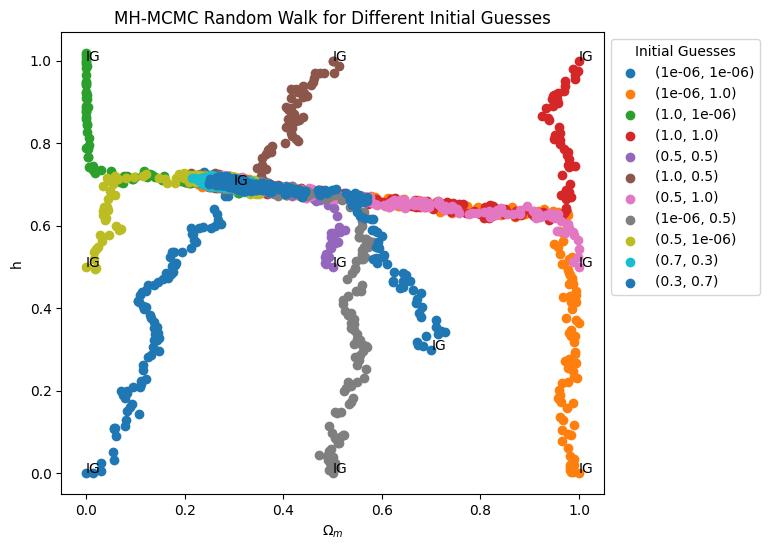

In [12]:
plt.figure(figsize=(7,6))
plt.title("MH-MCMC Random Walk for Different Initial Guesses")
plt.ylabel("h")
plt.xlabel(r"$\Omega_m$")
for i in range(len(initial_values)):
    plt.scatter( omega_m_values_is[i], h_values_is[i], label=initial_values[i])
    plt.legend(title='Initial Guesses',loc='upper left', bbox_to_anchor=(1, 1))
    plt.annotate("IG",initial_values[i])
plt.savefig('MultipleChains.png');

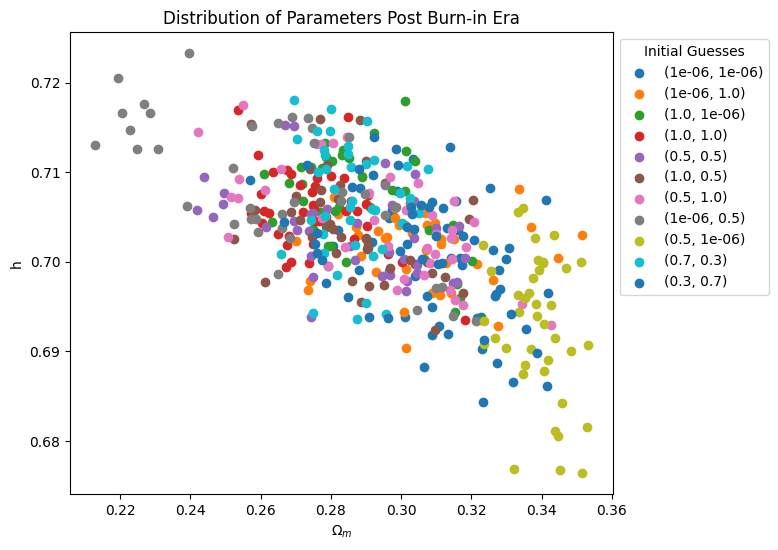

In [13]:
plt.figure(figsize=(7,6))
plt.title("Distribution of Parameters Post Burn-in Era")
plt.ylabel("h")
plt.xlabel(r"$\Omega_m$")
for i in range(len(initial_values)):
    plt.scatter( omega_m_values_is[i][-40:], h_values_is[i][-40:], label=initial_values[i])
    plt.legend(title='Initial Guesses',loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('DistributionMultiple.png');


#### Defining a function to calculate the GR Statistic

In [14]:
Nc = len(initial_values) # Number of chains

# Defining a function for calculating the GR Statistic
def GR_test(Ns, Nc, params_values_is):
    means_params = [np.mean(i[-Ns:]) for i in params_values_is]
    unbiased_var_param = [(Ns/(Ns-1))*(np.std(i[-Ns:])**2) for i in params_values_is]

    # Mean and Variance of chains
    mean_chains_param = np.mean(means_params)
    mean_unbiased_var_param = np.mean(unbiased_var_param) #sigma^2 chain

    # Variance in the means of the chains
    biased_var_params_means = np.std(means_params)**2 #sigma^2 mean
    R_hat = (((Nc-1)/(Nc))*mean_unbiased_var_param + (1/Nc)*biased_var_params_means)/mean_unbiased_var_param
    return R_hat

### Gelmon-Rubin Test for Convergence of $h$

Value of GR Statistic below threshold is 1.035022806889514 giving us the optimal length of the chain as 2 and above


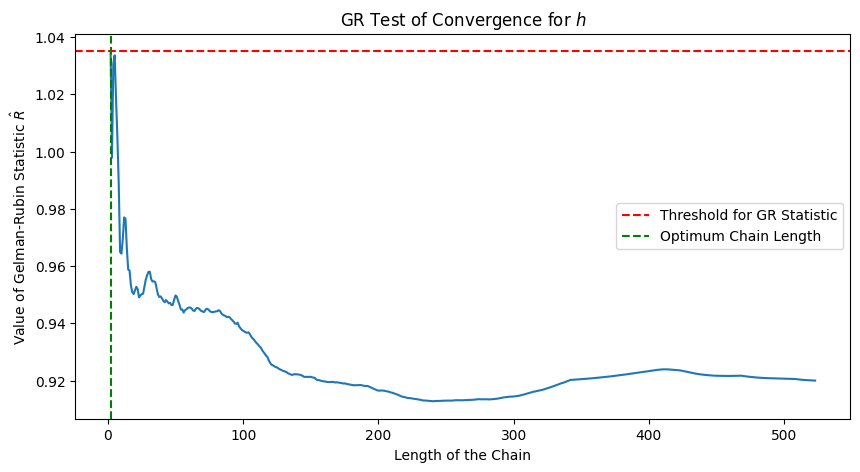

In [15]:
Diff_Ns = range(2,max([len(h_values_is[i]) for i in range(Nc)]))
GR_statistics = []
GR_threshold = 1.1
for Ns in Diff_Ns:
    GRS = GR_test(Ns, Nc, h_values_is)
    GR_statistics.append(GRS)
# threshold_index = np.argmax(Satistfy_threshold)
if max(GR_statistics)<GR_threshold:
    threshold_index=0
else:
    for i in range(len(Diff_Ns)):
        if GR_statistics[-i-1]<GR_threshold:
            pass
        else:
            threshold_index=i
            break

plt.figure(figsize=(10,5))
plt.plot(Diff_Ns, GR_statistics)
plt.axhline(GR_statistics[-threshold_index], color='r', linestyle='--', label='Threshold for GR Statistic')
plt.axvline(Diff_Ns[-threshold_index], color='g', linestyle='--', label='Optimum Chain Length')
plt.title(f"GR Test of Convergence for $h$")
plt.xlabel("Length of the Chain")
plt.ylabel(r"Value of Gelman-Rubin Statistic $\hat{R}$")
plt.legend()
print(f"Value of GR Statistic below threshold is {GR_statistics[-threshold_index]} giving us the optimal length of the chain as {Diff_Ns[-threshold_index]} and above")

### Gelmon-Rubin Test for Convergence of $\Omega_m$

Value of GR Statistic below threshold is 1.0985673533080544 giving us the optimal length of the chain as 13 and above


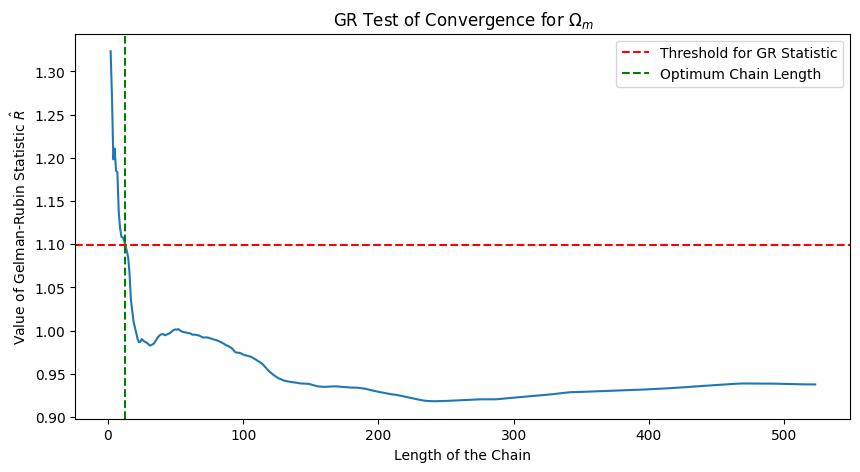

In [16]:
Diff_Ns = range(2,max([len(omega_m_values_is[i]) for i in range(Nc)]))
GR_statistics = []
GR_threshold = 1.1
for Ns in Diff_Ns:
    GRS = GR_test(Ns, Nc, omega_m_values_is)
    GR_statistics.append(GRS)
# threshold_index = np.argmax(Satistfy_threshold)
if max(GR_statistics)<GR_threshold:
    threshold_index=0
else:
    for i in range(len(Diff_Ns)):
        if GR_statistics[-i-1]<GR_threshold:
            pass
        else:
            threshold_index=i
            break

plt.figure(figsize=(10,5))
plt.plot(Diff_Ns, GR_statistics)
plt.axhline(GR_statistics[-threshold_index], color='r', linestyle='--', label='Threshold for GR Statistic')
plt.axvline(Diff_Ns[-threshold_index], color='g', linestyle='--', label='Optimum Chain Length')
plt.title(f"GR Test of Convergence for $\Omega_m$")
plt.xlabel("Length of the Chain")
plt.ylabel(r"Value of Gelman-Rubin Statistic $\hat{R}$")
plt.legend()
print(f"Value of GR Statistic below threshold is {GR_statistics[-threshold_index]} giving us the optimal length of the chain as {Diff_Ns[-threshold_index]} and above")

### Inference
From the above to calculations it is evident that the Gelman-Rubin Statistic for both the parameter is closer to 1 for chains with optimal lengths and above, we can conclude that the chains are well mixed and have sampled the target distribution. Also, we will have to take maximum of optimal length obtained for $h$ and $\Omega_m$, which we will give us GR-statistic less than the threshold.

The End